In [1]:
using Graphs
using Bloqade
using Random
using GenericTensorNetworks
using Optim
using PythonCall
plt = pyimport("matplotlib.pyplot");

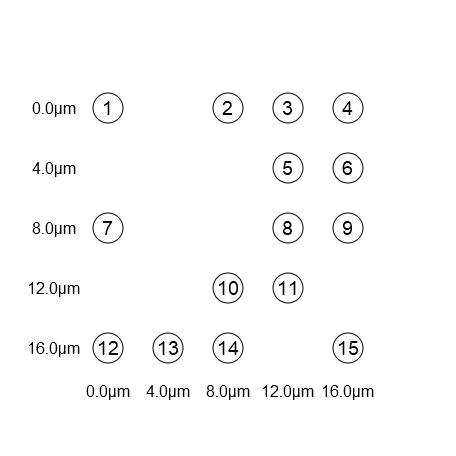

In [2]:
Random.seed!(2)
a = 4
k = sqrt(3*sqrt(10)) # Extended Kings lattice: Rb/a > 3
# k = sqrt(2*sqrt(2)) # Kings lattice
# k = 2.11
L = 5
atoms = generate_sites(SquareLattice(), L, L; scale = a) |> random_dropout(0.4)

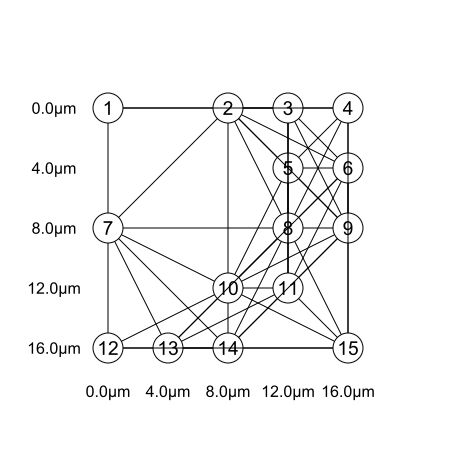

In [3]:
Bloqade.plot(atoms, blockade_radius = k*a)

# Get the exact solution using GenericTensorNetworks

In [4]:
graph = BloqadeMIS.unit_disk_graph(atoms, k*a)
all_optimal_configs = GenericTensorNetworks.solve(IndependentSet(graph), ConfigsMax())[]
all_optimal_configs.c

{100100000011000, 100100000001001, 100010000001001}

In [5]:
mis_size_and_counting = GenericTensorNetworks.solve(IndependentSet(graph), CountingMax())[]

(4.0, 3.0)ₜ

In [6]:
BloqadeMIS.exact_solve_mis(graph)

4

# Functions

In [7]:
function get_MIS_prob(reg::Union{ArrayReg, SubspaceArrayReg}, configs) # want to maxmimize this
    prob = 0
    x = [parse(Int, reverse(string(x)); base=2) for x in configs.c]
    for (c, amp) in BloqadeMIS.ConfigAmplitude(reg)
        if c in x
            prob+=abs2(amp)
        end
    end
    return prob
end

function get_waves(params::Vector{Float64}) # returns the pulses as a function of certain parameters
    
    Ω_max, Δ_start, Δ_end, schedule... = params
    
    t_start = 0.2
    T_max = 4
    t_end = T_max - 0.2
    t_interval = (t_end - t_start) / (length(schedule)+1)
    # Ω_max = 0.7 * 2π
    # Δ_start = -13 * 2π
    # Δ_end = 2.38 * 2π
    Δ_diff = Δ_end - Δ_start

    Δ_clock = [0.0, t_start]
    Δ_val = [Δ_start, Δ_start]
    for i in length(schedule)
        push!(Δ_val, Δ_start + schedule[i]*Δ_diff)
        push!(Δ_clock, t_start + i*t_interval)
    end
    push!(Δ_val, Δ_end); push!(Δ_val, Δ_end)
    push!(Δ_clock, t_end); push!(Δ_clock, T_max)
    Δ = piecewise_linear(clocks = Δ_clock, values = Δ_val);
    Ω = piecewise_linear(clocks = [0.0, t_start, t_end, T_max], values = [0, Ω_max, Ω_max, 0]);
    return Ω, Δ
end

function plot_waves(params::Vector{Float64})
    Ω, Δ = get_waves(params)

    graph, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
    Bloqade.plot!(ax1, Ω)
    ax1.set_ylabel("Ω/2π (MHz)")
    Bloqade.plot!(ax2, Δ)
    ax2.set_ylabel("Δ/2π (MHz)")
    return graph
end

plot_waves (generic function with 1 method)

# Schedule optimization

## Initial value

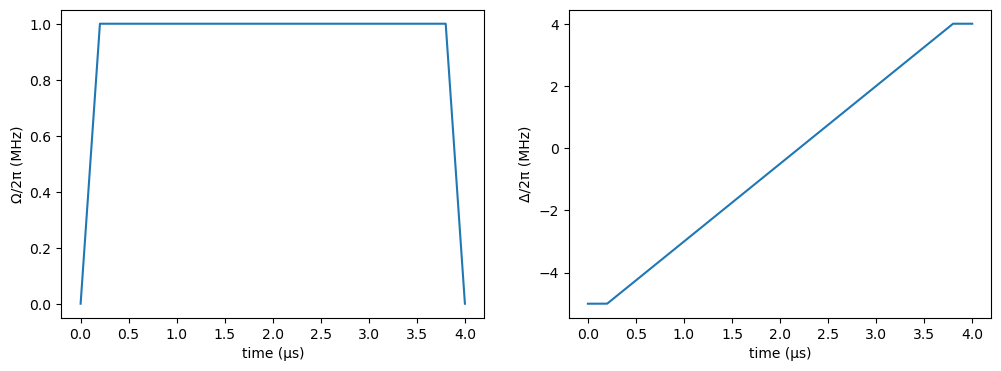

In [8]:
T_max = 4
Ω_max_0 = 1 * 2π
Δ_start = -5 * 2π
Δ_end = 4 * 2π
x0 = [Ω_max_0, Δ_start, Δ_end, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
Ω0, Δ0 = get_waves(x0)
plot_waves(x0)

In [10]:
hamiltonian0 = rydberg_h(atoms; Ω = Ω0, Δ = Δ0)
subspace = blockade_subspace(atoms, k*a/2)
prob0 = SchrodingerProblem(zero_state(subspace), T_max, hamiltonian0)
emulate!(prob0)

SchrodingerProblem:
  register info:
    type: SubspaceArrayReg{2, ComplexF64, Vector{ComplexF64}, Subspace{Int64, Vector{Int64}}}
    storage size: 40 bytes

  time span (μs): (0.0, 4.0)

  equation: 
    storage size: 188.633 KiB
    expression:
nqubits: 15
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


    algorithm: DP8(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),)
  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false
    reltol: 1.0e-10
    abstol: 1.0e-10
    alias_u0: true


In [11]:
best5_bit_strings_0 = most_probable(prob0.reg, 5)
BloqadeMIS.is_independent_set.(best5_bit_strings_0, Ref(graph))

5-element BitVector:
 0
 0
 1
 0
 0

In [12]:
get_MIS_prob(prob0.reg, all_optimal_configs)

0.25587568370639463

## Optimize

In [13]:
function loss(atoms::AtomList, x::Vector{Float64}, configs, T_max)
    Ω, Δ = get_waves(x)
    hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
    subspace = blockade_subspace(atoms, k*a/2)
    prob = SchrodingerProblem(zero_state(subspace), T_max, hamiltonian)
    emulate!(prob)
    return -get_MIS_prob(prob.reg, configs), prob.reg, Δ
end

loss (generic function with 1 method)

In [14]:
optresult = Optim.optimize(x -> loss(atoms, x, all_optimal_configs, T_max)[1], x0)

 * Status: success

 * Candidate solution
    Final objective value:     -6.938693e-01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   121  (vs limit Inf)
    Iterations:    319
    f(x) calls:    680


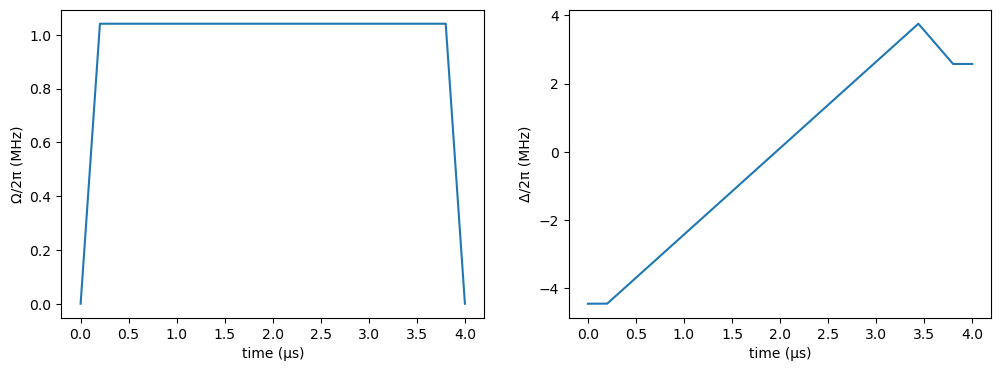

In [15]:
plot_waves(optresult.minimizer)

In [66]:
Δ_opt

                    ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀Waveform{_, Float64}⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
                    ┌────────────────────────────────────────┐ 
                  4 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⠶⡄⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡴⠋⠀⠀⠙⢦⡀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⠖⠋⠀⠀⠀⠀⠀⠀⠙⠒⠒│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡤⠞⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡴⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⠞⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⢤⡴⠾⠥⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤│ 
   value / 2π (MHz) │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⡴⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⠞⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡴⠋⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⠔⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⢀⣠⠞⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⢀⡴⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⣠⠞⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

In [16]:
Ω_opt, Δ_opt = get_waves(optresult.minimizer)
hamiltonian = rydberg_h(atoms; Ω = Ω_opt, Δ = Δ_opt, ϕ=Waveform(t->0.0, T_max))
subspace = blockade_subspace(atoms, k*a/2)
prob = SchrodingerProblem(zero_state(subspace), T_max, hamiltonian)
emulate!(prob)

SchrodingerProblem:
  register info:
    type: SubspaceArrayReg{2, ComplexF64, Vector{ComplexF64}, Subspace{Int64, Vector{Int64}}}
    storage size: 40 bytes

  time span (μs): (0.0, 4.0)

  equation: 
    storage size: 278.945 KiB
    expression:
nqubits: 15
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅∑ e^{ϕ(t) ⋅ im} |0⟩⟨1| + e^{-ϕ(t) ⋅ im} |1⟩⟨0|
└─ [-] Δ(t) ⋅ ∑ n_i


    algorithm: DP8(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),)
  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false
    reltol: 1.0e-10
    abstol: 1.0e-10
    alias_u0: true


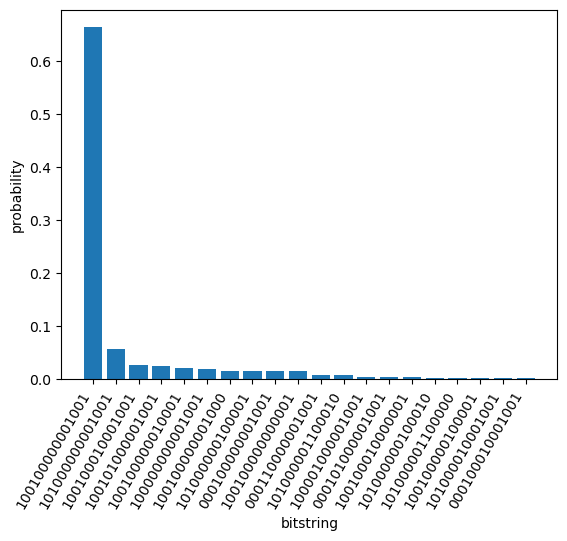

In [17]:
bitstring_hist(prob.reg; nlargest = 20)

In [18]:
get_MIS_prob(prob.reg, all_optimal_configs)

0.693869348885177

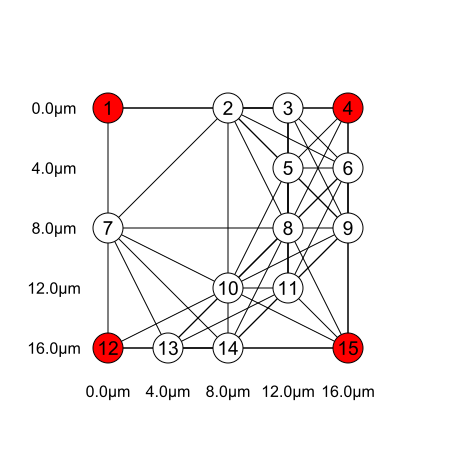

In [35]:
best_bit_strings = most_probable(prob.reg, 2)
Bloqade.plot(atoms, blockade_radius = k*a; colors = [iszero(b) ? "white" : "red" for b ∈ best_bit_strings[1]])

In [69]:
Δ_opt.f.clocks

5-element Vector{Float64}:
 0.0
 0.2
 3.44
 3.8
 4.0

In [73]:
Δ_opt.f.values

5-element Vector{Float64}:
 -27.971415389660272
 -27.971415389660272
  23.594454699681336
  16.185740815456843
  16.185740815456843

In [71]:
Ω_opt.f.values

4-element Vector{Float64}:
 0.0
 6.544289568279506
 6.544289568279506
 0.0

In [72]:
Ω_opt.f.clocks

4-element Vector{Float64}:
 0.0
 0.2
 3.8
 4.0

In [75]:
omega_durations = [0.2, 3.24, 0.36, 0.2]
omega_values = [0, 6.544289568279506, 6.544289568279506, 0.0]

delta_durations = [0.2, 3.6, 0.2]
delta_values = [-27.971415389660272, -27.971415389660272, 23.594454699681336, 16.185740815456843, 16.185740815456843]

Base.Meta.ParseError: ParseError:
# Error @ c:\Users\ivash\projects\QuantumQuants\julia-tests-mis_hw.ipynb:4:16

delta_durations []
#              ╙ ── whitespace is not allowed here